# Richter's Predictor: Modeling Earthquake Damage




### Problem Statement

> Based on aspects of building location and construction, our goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.


Importing Necessary Libraries :



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from scipy.stats import iqr
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import lightgbm as lgb 
import xgboost as xgb 

### Reading Datasets

In [ ]:
train_X = pd.read_csv("train_values.csv")
train_Y = pd.read_csv("train_labels.csv")
test_X =  pd.read_csv("test_values.csv")
print("We have "+str(train_X.shape[0])+" set of Training data and "+str(test_X.shape[0])+" set of testing data "+"Totally we Have "+str(train_X.shape[0]+test_X.shape[0])+" Dataset...")

We have 260601 set of Training data and 86868 set of testing data Totally we Have 347469 Dataset...


#### Display Training Dataset

In [ ]:
train_X.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_Y.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


#### Merge   _train_X_   and   _train_Y_   into   _train dataframe_   for   Exploring   the   dataset :





In [ ]:
train = pd.merge(train_X,train_Y)
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


Remove _building_id_ 
> We are not making Predictions with Building_id

In [ ]:
train.drop('building_id',axis=1,inplace=True)

In [ ]:
test_X.drop('building_id',axis=1,inplace=True)

**Level of Damage Grades in the Given Dataset**
>no of tuples that fall in each level of Damage

Grade1 :25124->9.64079186188848%
Grade2 :148259->56.89118614280068%
Grade3 :87218->33.468021995310835%


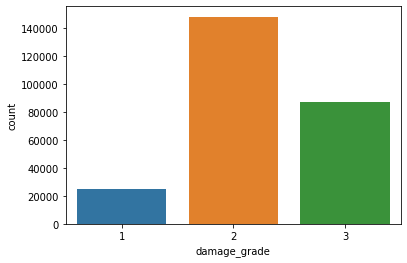

In [ ]:
sns.countplot(train.damage_grade)
print('Grade1 :'+str(sum(train.damage_grade == 1))+'->'+str(sum(train.damage_grade == 1)/train.shape[0]*100)+'%')
print('Grade2 :'+str(sum(train.damage_grade == 2))+'->'+str(sum(train.damage_grade == 2)/train.shape[0]*100)+'%')
print('Grade3 :'+str(sum(train.damage_grade == 3))+'->'+str(sum(train.damage_grade == 3)/train.shape[0]*100)+'%')

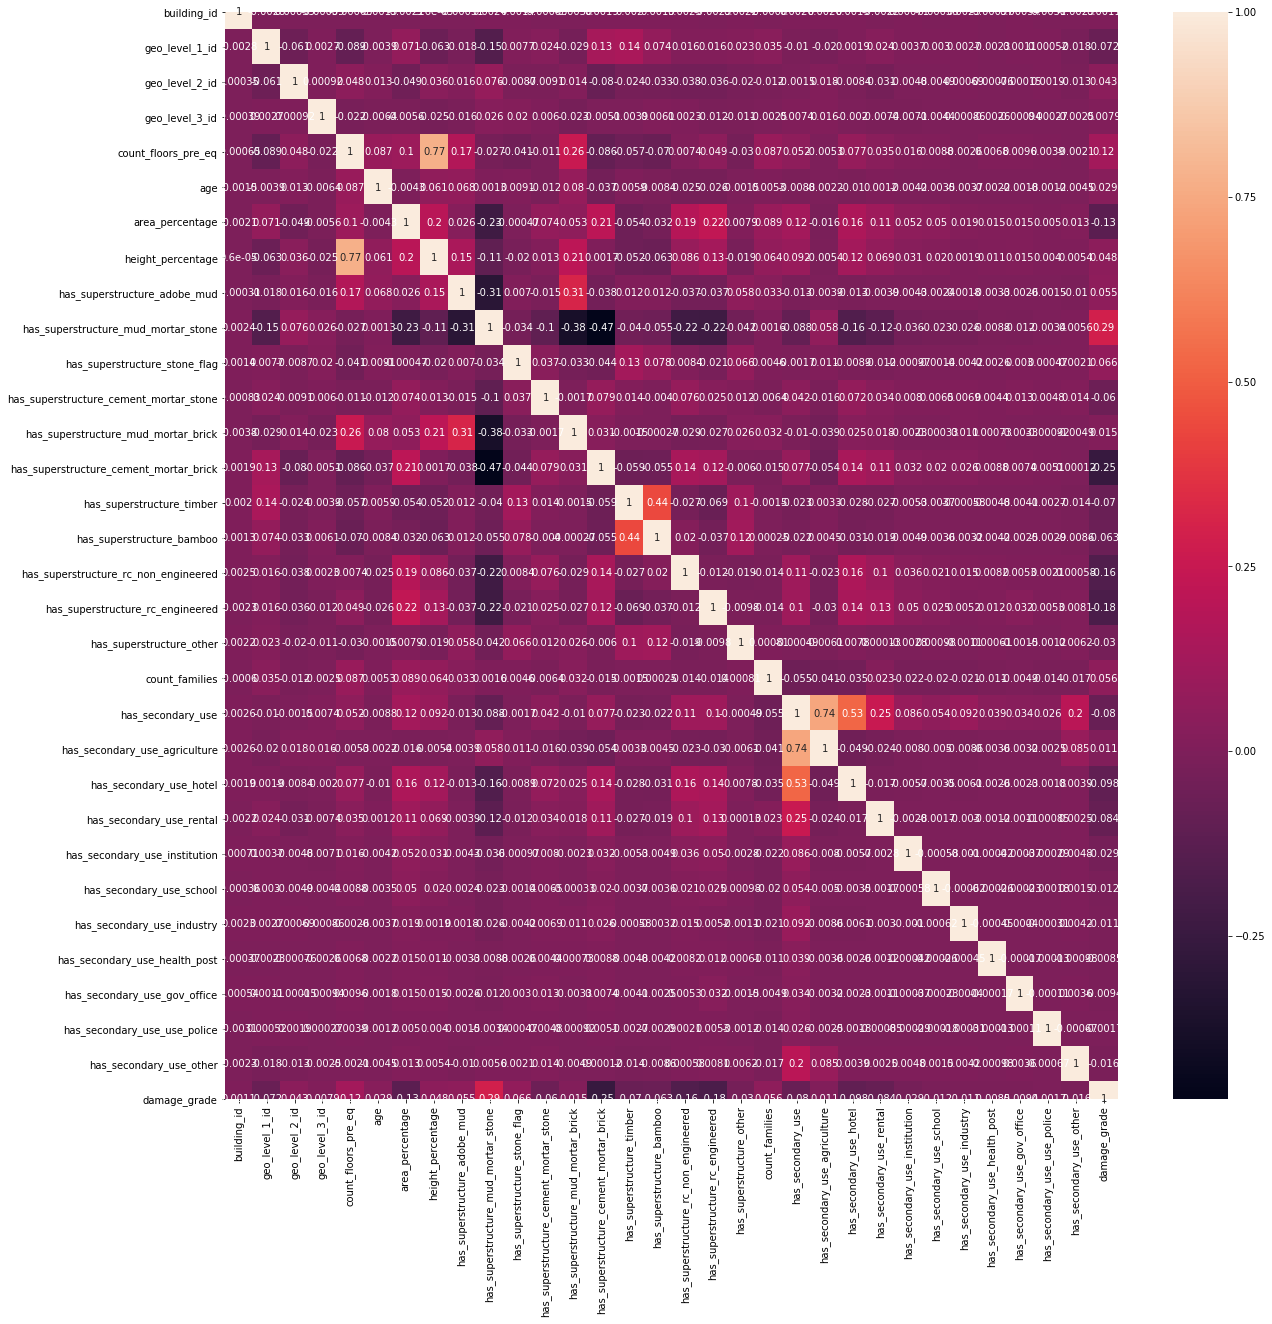

In [ ]:
data  = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data,annot=True)

## Preprocessing

As OneHot encoding didnt give expected Results. Converting Categories in each categorical attributes to some numerical values.

In [ ]:
cleanup_letters = {"land_surface_condition": {"n": 1, "o": 2, "t":3},
                "foundation_type": {"h": 1, "i": 2, "r": 3, "u": 4, "w": 5},               
                "roof_type": {"n": 1, "q": 2, "x": 3},
                "ground_floor_type": {"f": 1, "m": 2, "v": 3, "x": 4, "z": 5},
                "other_floor_type": {"j": 1, "q": 2, "s": 3, "x": 4},
                "position": {"j": 1, "o": 2, "s": 3, "t": 4},
                "plan_configuration": {"a": 1, "c": 2, "d": 3, "f": 4, "m": 5, "n": 6, "o": 7, "q": 8, "s": 9, "u":10},
                "legal_ownership_status": {"a": 1, "r": 2, "v": 3, "w": 4}             
               }
train.replace(cleanup_letters, inplace=True)
test_X.replace(cleanup_letters, inplace=True)

In [ ]:
category_cols = [ 'roof_type','legal_ownership_status', 'foundation_type', 'land_surface_condition', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration','geo_level_3_id','geo_level_2_id','geo_level_1_id']

### Assigning weights to class 2 and 3 :

In [ ]:
w=[]
for index,row in train.iterrows():
  if(row['damage_grade']==1):
    w.append(1)
  elif(row['damage_grade']==2):
    w.append(1.2)
  else:
    w.append(1.2)

In [ ]:
train['weight']=w

In [ ]:
train.drop('weight',axis=1,inplace=True)

Model Building :



In [ ]:
Y = train.damage_grade
X =train.drop('damage_grade',axis=1,inplace=False)

Splitting the given data into training and validation set   :



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)


In [ ]:
w1 = X_train['weight']
w2 = X_test['weight']

# RandomForest Classifier

*Applied RandomForest Classifier with alomost default parameters with 1000 estimators*

In [ ]:
nX_train,nX_test,ny_train,ny_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
xgb = RandomForestClassifier(n_estimators=100,max_features=25,min_samples_leaf=5,n_jobs=-1,random_state=42,min_samples_split=6)

In [ ]:
xgb.fit(nX_train,ny_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(xgb,cv=2 ,scoring='f1_weighted', n_jobs=4)

visualizer.fit(X,Y)      
visualizer.show()  

In [ ]:
y_pred1 = xgb.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
res=f1_score(y_test,y_pred1, average='micro')
res

0.7421001131981351

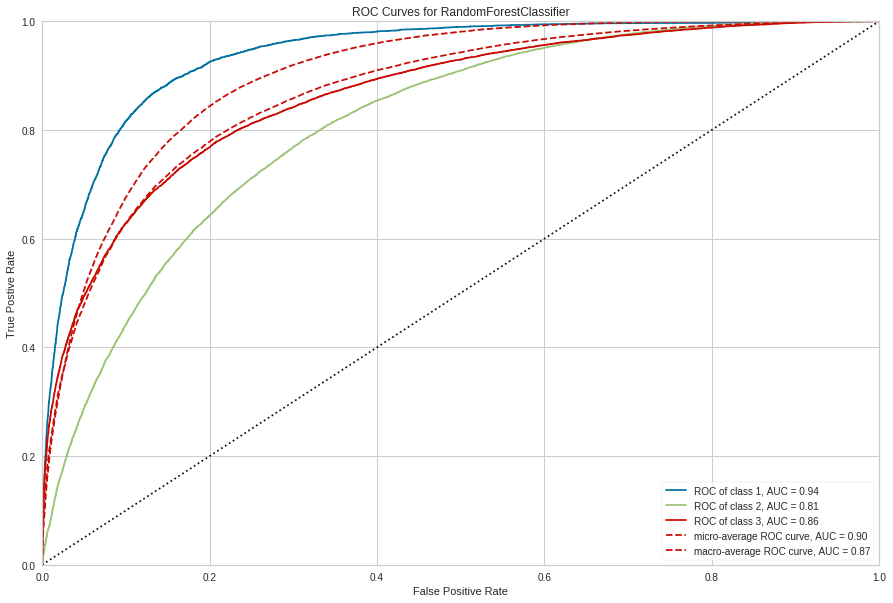

In [ ]:
classes = ['1','2','3']
rocrd = ROCAUC(xgb, size=(1080, 720), classes=classes)
rocrd.score(X_test, y_test)  
r = rocrd.poof()

### Inference :
   - Got F1score of 0.7421 for validation data.
   - Upon increasing the no of estimators the model overfitted the training data.
   - From the above graph we can oberserve the AUC for all the three classes.

# XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier(max_depth=10,learning_rate=0.05,n_estimators=700,min_child_weight=2,objective='multiclass')
xg.fit(nX_train,ny_train)
pred = xg.predict(X_test)

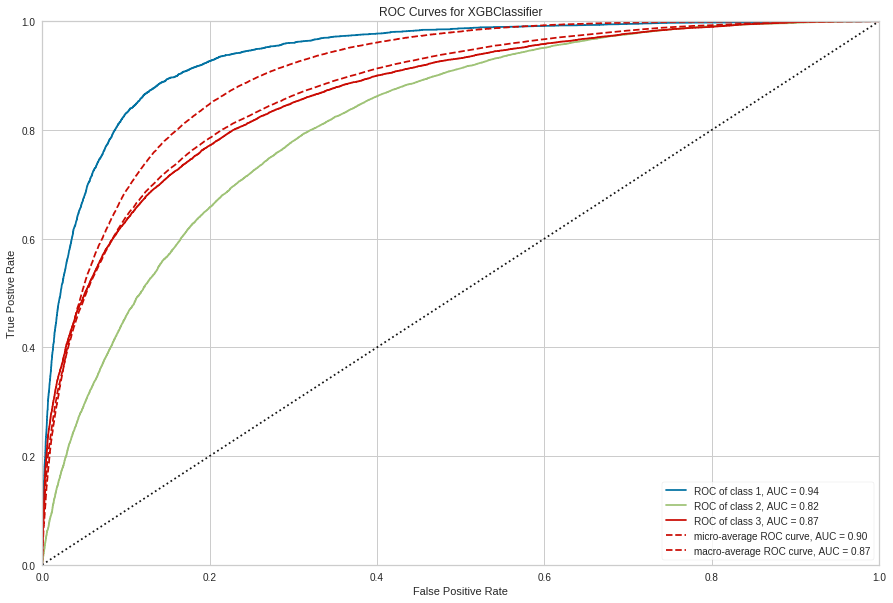

In [ ]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
classes = ['1','2','3']
rocauc = ROCAUC(xg, size=(1080, 720), classes=classes)
rocauc.score(X_test, y_test)  
r = rocauc.poof()

### Inference :
   - Got F1 score of 0.7460 for validation dataset. 
   - Xgboost of comparatively better than RandomForest because it is Boosting algorithm where as RandomForest is Bagging algorithm.
   - Hyperparameter Tunning is difficult.
   - More time consuming than RandomForest.
   - AUC for class 2 and 3 are slightly better than that of RandomForest.

# LGBClassifier

- Preparing training dataset for lgbclassifier.

In [ ]:
train_data=lgb.Dataset(X,label=Y,categorical_feature=category_cols,weight=w)

In [ ]:
param = {'num_boost_round':1080,'num_leaves':350, 'objective':'multiclass','max_depth':10,'learning_rate':.05,'max_bin':200,'num_class':4,
         'feature_fraction':0.5}#,'lambda_l2':9}

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train,categorical_feature=category_cols,weight=w1)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train,categorical_feature=category_cols,weight=w2)
evals_result = {} 

In [ ]:
print('Start training...')

# train
gbm = lgb.train(param,
                lgb_train,
                valid_sets=[lgb_train, lgb_valid],
                evals_result=evals_result,
                verbose_eval=10,
                early_stopping_rounds=50)


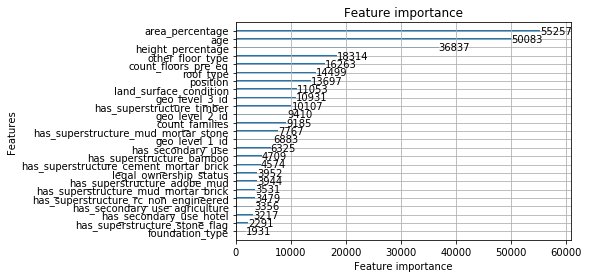

In [ ]:
lgb.plot_importance(gbm,max_num_features=25)
plt.show()

In [ ]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
pred = [np.argmax(line) for line in y_pred]
pred = pd.Series(pred)
from sklearn.metrics import f1_score
res=f1_score(y_test,pred, average='micro')
res

0.7510408472592621

In [ ]:
lg = lgb.train(param,train_data)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [ ]:
y_pred = lg.predict(X_test)
pred = [np.argmax(line) for line in y_pred]
pred = pd.Series(pred)
from sklearn.metrics import f1_score
res=f1_score(y_test,pred, average='micro')
res

0.7520385257381861

In [ ]:
cv_results = lgb.cv(param,lgb_train, num_boost_round=1000, nfold=4, 
                    verbose_eval=20, early_stopping_rounds=40)

In [ ]:
print('Current parameters:\n', param)
print('\nBest num_boost_round:', len(cv_results['multi_logloss-mean']))
print('Best CV mean loss:', cv_results['multi_logloss-mean'][-1])
print('Best CV stdv:', cv_results['multi_logloss-stdv'][-1])

Current parameters:
 {'num_leaves': 350, 'objective': 'multiclass', 'max_depth': 10, 'learning_rate': 0.05, 'max_bin': 200, 'num_class': 4, 'feature_fraction': 0.5}

Best num_boost_round: 447
Best CV mean loss: 0.5640935788248584
Best CV stdv: 0.001853666903585507


In [ ]:
ls = lgb.LGBMClassifier(num_leaves=350, objective='multiclass',max_depth=10,learning_rate=0.05,max_bin=200,num_class=4,feature_fraction=0.5,n_estimators=1150)
ls.fit(X_train,y_train,categorical_feature=category_cols,sample_weight=w1)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['foundation_type', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'ground_floor_type', 'land_surface_condition', 'legal_ownership_status', 'other_floor_type', 'plan_configuration', 'position', 'roof_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.5, importance_type='split',
               learning_rate=0.05, max_bin=200, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1150, n_jobs=-1, num_class=4, num_leaves=350,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
from sklearn.model_selection import GridSearchCV

paramgrid = {'num_leaves':[340,350],'objective':['multiclass'],'max_depth':[9,10],'learning_rate':[0.05],'max_bin':[200,210],'num_class':4,'feature_fraction':[0.5,0.6]
             ,'num_iterations':1100}

In [ ]:
gs = GridSearchCV(mod1, paramgrid, cv=4,n_jobs=-1)

In [ ]:
gs.fit(X_train,y_train)

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

{'feature_fraction': 0.5, 'learning_rate': 0.05, 'max_bin': 200, 'max_depth': 10, 'num_class': 4, 'num_iterations': 1100, 'num_leaves': 350, 'objective': 'multiclass'}
0.7426179969301612


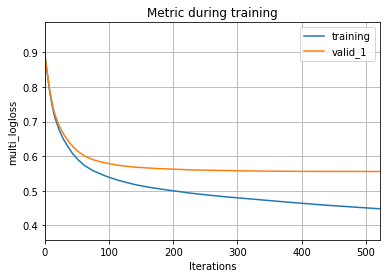

<Figure size 36000x36000 with 0 Axes>

In [ ]:
ax = lgb.plot_metric(evals_result, metric='multi_logloss')
plt.show()

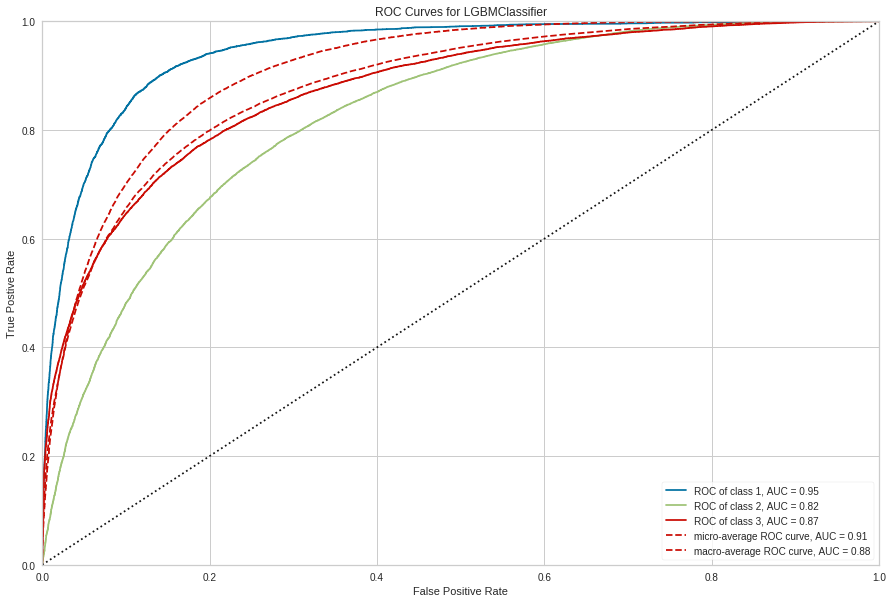

In [ ]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
classes = ['1','2','3']
rocauc = ROCAUC(ls, size=(1080, 720), classes=classes)
rocauc.score(X_test, y_test)  
r = rocauc.poof()

### Inference :
   - Got better F1 score of 0.7516 compared to other models.
   - Fast to train.
   - The cross validation loss Standard deviation is less (0.00185)
   - The Model tends to overfitt (high varience) as we increase the training iterations.
   - Need to tune Highper parameters that regulates overfitting.
   - ROC curves is almost comparable to that of XgBoost,only change is lgb has got slightly better micro-average(0.91) and better AUC for class 1(0.95).

### Post Processing :
- By Observing the ROC curves we can see that classifier is performing poor with respect to class 2 and 3.
- So Assigned initial weights to training tuples based on thier class label. 

## CATBoost


In [ ]:
from catboost import Pool, CatBoostClassifier

In [ ]:
train_pool = Pool(data=nX_train, label=ny_train)
test_pool = Pool(data=X_test, label=y_test) 

In [ ]:
col = []
col.append(X_train.columns.get_loc("roof_type"))
col.append(X_train.columns.get_loc("legal_ownership_status"))
col.append(X_train.columns.get_loc("foundation_type"))
col.append(X_train.columns.get_loc("land_surface_condition"))
col.append(X_train.columns.get_loc("ground_floor_type"))
col.append(X_train.columns.get_loc("other_floor_type"))
col.append(X_train.columns.get_loc("position"))
col.append(X_train.columns.get_loc("plan_configuration"))
col.append(X_train.columns.get_loc("geo_level_3_id"))
col.append(X_train.columns.get_loc("geo_level_2_id"))
col.append(X_train.columns.get_loc("geo_level_1_id"))

In [ ]:
model = CatBoostClassifier(
    iterations=500,cat_features=col,
    learning_rate=0.1,
    random_strength=0.1,
    depth=10,
    loss_function='MultiClass',
    eval_metric='AUC',
    leaf_estimation_method='Newton',use_best_model=True
)

In [ ]:
model.fit(nX_train,ny_train,plot=True,eval_set=(nX_test,ny_test))

In [ ]:
k=model.predict(X_test)

In [ ]:
k = np.asarray(k,np.int)

In [ ]:
from sklearn.metrics import f1_score
res=f1_score(y_test,k, average='micro')
res

0.7499472381573646

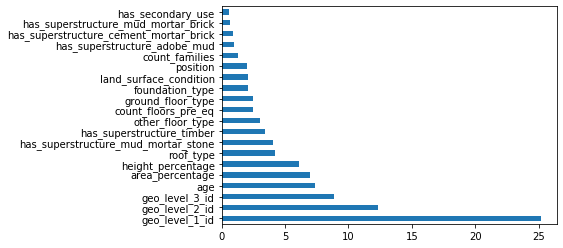

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

### Inference :
- By observing the feature importance graph of catboost classifier 'geo_level_id' gets highest importance whereas in LightGBM 'area_percentage' gets the highest.
- F1 score :  0.7499.

# Stacking

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_jobs=-1,criterion='gini',n_estimators=800, max_depth=None,min_samples_split=10, random_state=2019,max_features=None,min_samples_leaf=3)
clf.fit(nX_train,ny_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=None, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                     oob_score=False, random_state=2019, verbose=0,
                     warm_start=False)

In [ ]:
B10 = clf.predict(nX_test)
B11 = xgb.predict(nX_test)
B12 = lg.predict(nX_test)
B13 = model.predict(nX_test)
B14 = xg.predict(nX_test)

In [ ]:
C10 = clf.predict(X_test)
C11 = xgb.predict(X_test)
C12 = lg.predict(X_test)
C13 = model.predict(X_test)
C14 = xg.predict(X_test)

In [ ]:
pred = [np.argmax(line) for line in C12]
C12 = pd.Series(pred)
C12

In [ ]:
pred = [np.argmax(line) for line in B12]
B12 = pd.Series(pred)
B12

In [ ]:
B1 = pd.DataFrame()
B1['B10'] = B10
B1['B11'] = B11
#B1['B12'] = B12.values
B1['B13'] = np.asarray(B13,np.int)
B1['B14'] = B14
B1

,B10,B11,B13,B14
0,3,3,3,3
1,2,2,2,2
2,2,2,2,2
3,2,2,2,2
4,2,2,2,2
...,...,...,...,...
41691,2,2,2,2
41692,3,2,3,3
41693,3,3,3,3
41694,2,2,2,2


In [ ]:
C1 = pd.DataFrame()
C1['B10'] = C10
C1['B11'] = C11
#C1['B12'] = C12.values
C1['B13'] =np.asarray(C13,np.int)
C1['B14'] = C14
C1

,B10,B11,B13,B14
0,2,2,2,2
1,3,3,3,3
2,2,2,2,2
3,2,3,3,2
4,2,2,2,2
...,...,...,...,...
52116,3,3,3,3
52117,3,3,3,3
52118,2,2,2,2
52119,2,2,2,2


In [ ]:
train_data = lgb.Dataset(B1,label=ny_test)
l = lgb.train(param,train_data)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
y = l.predict(C1)

In [ ]:
pred = [np.argmax(line) for line in y]
pred = pd.Series(pred)
from sklearn.metrics import f1_score
res=f1_score(y_test,pred, average='micro')
res

0.7480669979470845

In [ ]:
from xgboost import XGBClassifier
xxg = XGBClassifier(max_depth=10,learning_rate=0.05,n_estimators=700,min_child_weight=2,objective='multiclass')
xxg.fit(B1,ny_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y = xxg.predict(C1)

In [ ]:
from sklearn.metrics import f1_score
res=f1_score(y_test,y, average='micro')
res

0.7487193261833043

### Inference :
- Base Classifiers  - {ExtraTree,RandomForest,LightGbm,Catboost).
- Meta Classifier - XgBoost.
- F1 score didnt improve compared to highest attained by single classifier.
- Reason is in order to get good results by stacking the base classifiers must be selected in such a way that each classifier performs better on any individual class,But base classifiers results were almost same.


###  Creating CSV file of classifications for test dataset :  

In [ ]:
test_X.drop('building_id',axis=1,inplace=True)

In [ ]:
y1=lg.predict(test_X)
y = [np.argmax(line) for line in y1]
y = pd.Series(y)

In [ ]:
yr = np.asarray(y)
yr

array([3, 2, 2, ..., 2, 2, 1])

In [ ]:
submission_format = pd.read_csv('/content/drive/My Drive/DMA Project/submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data=yr,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
  my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv('submissionFinalW5own.csv')

### References
- Preprocessing Steps
  - https://www.geeksforgeeks.org/data-preprocessing-in-data-mining/
- Implimented example
  - https://github.com/SAR2652/Richter-s-Predictor-Modeling-Earthquake-Damage
- Encoding Categorical Data
  - https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
- Difference Between one Hot Encodeing and Dummy Encoding
  - https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn
- LightGB classifier
  - https://lightgbm.readthedocs.io/en/latest/index.html
  -https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/
- Others
  - https://www.coursehero.com/file/p39iat0/Sturges-formula-to-find-number-of-classes-is-given-as-follows-K-1-3322-log-N-K/